# Database Initialization

In [27]:
db = 'twitterGender'
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
myDB = URL(drivername='mysql', database=db, query={ 'read_default_file' : '/home/fatal/.my.cnf' })
engine = create_engine(name_or_url=myDB)
#conn = engine.connect()


# Necessary Libraries

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as ss
import pandas as pd
import warnings

import time
import pdb


# Find Best Fit Distribution
## Function name: best_fit_distribution
**Args:**
* data -> a series of data values (like group norms in our case)
* bins -> how many bins we want to divide the data into (default = 200)
* ax -> axes subplots (default None)
  * subplot of the data with x and y limits set
  * If given, this function will add histogram of data + all different distribution lines to this subplot

**Returns:**
* Best_Distribution_name -> winner among all distributions
* Best_SSE -> Minimum sum of squared error
* Best_params -> parameters of the best distribution which has at least two parameters of "Location" and "Scale" + any additional parameters based on the distribution type

**What it does?**
* Creates a histogram of the data divided to <BINS> bins
* Sets x as the center of each bin
* Sets y as the frequency value of each bin (normed = True)
* Finds the best fit distribution among previously defined distributions based on the SSE of the returned value and the actual value
  * Uses scipy.stats distribution methods **fit** and **pdf**
  * scipy.stats current Distributions are **norm**, **expon**, and **lognorm** for now
* If ax is set, it adds histogram and all the distributions lines with their MLE parameters to that

In [29]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    s0 = time.time()
    y, x = np.histogram(data, bins=bins, normed=True)
    s1 = time.time()
    x = (x + np.roll(x, -1))[:-1] / 2.0
    s2 = time.time()
    #print('hist:' + str(round(s1-s0)) + ',roll:'+ str(round(s2-s1)))
    DISTRIBUTIONS = [
        ss.norm, ss.expon, ss.lognorm
    ]
    # Best holders
    best_distribution = ss.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                #s3 = time.time()
                if distribution.name == 'lognorm':
                    logdata = np.log(data)
                    estimated_mu, estimated_sigma = ss.norm.fit(logdata)
                    params = [estimated_sigma, 0, np.exp(estimated_mu)]
                    #params1 = distribution.fit(data, floc=0)
                else:
                    params = distribution.fit(data)
                    
                #s4 = time.time()
                #print(distribution.name + ':' + str(round(s4-s3)))

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            print(Exception.message)
            pass

    return (best_distribution.name, best_sse, best_params)

# Create a pdf from a distribution and its parameters
## Function name: make_pdf
**Args:** 
* Distribution name
* Parameters of that distribution

**Returns:**
* PDF value of that distribution for 10000 data points from start point to the end point of the distribution.
  * start point -> exclude 0.01 percent of the distribution from left
  * end point -> exclude 0.01 percent of the distribution from right

In [30]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


# Draw Two plots for the data
One including all tested distributions and the other the best fitted one

**Args:**
* data -> series of raw data for one feature
* title -> title of the plots added in first line of the title (Usually includes feature name)

**What it does?**
draws two plots for this data
* First one contains all the distributions over the histogram of the data with their MLE parameters.
For this we call function best_fit_distribution with a previously initiated subplot ax with the data ranges.
* Second one contains the winner, the fitted distribution with minimum SSE among all.
For this we generate a pdf out of 10000 samples using the parameters of the winning distribution and draw it.

In [31]:
def draw_plots(data, title):
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_fit_name, best_sse, best_fit_paramms = best_fit_distribution(data, 200, ax)
    ax.legend(loc='upper right')
    best_dist = getattr(ss, best_fit_name)

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title(str(title) + '\n All Fitted Distributions')
    ax.set_xlabel('Group Norm')
    ax.set_ylabel('Frequency')

    # Make PDF
    pdf = make_pdf(best_dist, best_fit_paramms)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_paramms)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(str(title) + ' - best fit distribution \n' + dist_str)
    ax.set_xlabel('Group Norm')
    ax.set_ylabel('Frequency')
    ax.set_ylim(dataYLim)


# Distribution of best fit distributions among all different features

## Gives you count of features in each distribution

Also, saves 5 features with least SSE for their best fit distribution and 5 features with worst (most) SSE for their best fit distributions

In [32]:
# Load DATA from DB
table_name = 'feat$cat_LIWC2007$msgs_r2k$user_id$16to16'
stime = time.time()
# Load distinct features
features = pd.read_sql('select distinct feat from ' + table_name, con=engine)
feat_cnt = len(features)
print(str(feat_cnt) + ' unique features' )
DISTRIBUTIONS = [
    ss.norm, ss.expon, ss.lognorm
]
pval_threshold = 0.05
cntr = 1
usr_best_fit = []
# Load data feature by feature and find the best distribution for each feature
for index, eachfeat in features.iterrows():
    feat = eachfeat.feat
    qs = time.time()
    raw_df = pd.read_sql("select * from " + table_name + " where feat = '" + feat + "'", con=engine)
    qe = time.time()
    data = raw_df.group_norm.tolist()
    #pdb.set_trace()
    for distribution in DISTRIBUTIONS:
        # fit dist to data
        if distribution.name == 'lognorm':
            #ANDERSON-DARLING
            #statistics, critical_val, significance = ss.anderson(np.log(data), 'norm')
            #KORMOGOROV-SMIRNOV
            statistics, pval = ss.kstest(np.log(data), 'norm')
        else:
            #ANDERSON-DARLING
            #statistics, critical_val, significance = ss.anderson(data, distribution.name)
            #KORMOGOROV-SMIRNOV
            statistics, pval = ss.kstest(data, distribution.name)
        if pval < pval_threshold:
        #if statistics < critical_val[significance==5]:
            #ANDERSON-DARLING
            #usr_best_fit.append([feat, len(raw_df), distribution.name, statistics, critical_val[significance==5]])
            #KORMOGOROV-SMIRNOV
            usr_best_fit.append([feat, len(raw_df), distribution.name, statistics, pval])
    beste = time.time()
    x = str(cntr) + ' out of ' + str(feat_cnt) + ', ' + feat + ':' + str(len(raw_df)) + ' rows, ' + \
    str(round(qe-qs)) + ',' + str(round(beste-qe))
    print x, '\r',
    #print x
    cntr += 1
etime = time.time()
print
print('overal time: ' + str(round(etime-stime)))
df = pd.DataFrame(usr_best_fit, columns=['feat', 'count', 'accepted_dist', 'statistics', 'pval'])
feat_dist = df.groupby('accepted_dist').feat.count()
print(feat_dist)

df = df.sort_values('accepted_dist')
least_sse_feat = df.head()['feat']
most_sse_feat = df.tail()['feat']

64 unique features
64 out of 64, YOU:2067 rows, 0.0,0.0 
overal time: 1.0
accepted_dist
expon      64
lognorm    64
norm       64
Name: feat, dtype: int64


In [20]:
data

[0.0103335513407456,
 0.011060282300538699,
 0.0104124656278644,
 0.012303714053343901,
 0.0082370763113046794,
 0.0098853757981383107,
 0.012395001024380301,
 0.0139590745314872,
 0.0104665949329942,
 0.0135295375464106,
 0.0092417023853152494,
 0.00893610230925297,
 0.012484821535462,
 0.010026179468612499,
 0.0135202611868639,
 0.0060850042579546296,
 0.0099654530959341001,
 0.0016785180211798499,
 0.0090220016098738892,
 0.0025040419574904301,
 0.0013572292899891999,
 0.0073423624547303704,
 0.013801698670605701,
 0.011638494121372901,
 0.0127856552863436,
 0.0010282564882984401,
 0.0019375610040353701,
 0.000218231699713181,
 0.0096164063330145596,
 0.0082462379451182493,
 0.0098806559073708802,
 0.0038745273076684701,
 0.0073421439060205604,
 0.024100994644223401,
 0.0083011003373425901,
 0.00063129099007470295,
 0.014829794405123,
 0.010606853441570399,
 0.00410958904109589,
 0.0084957968163119207,
 0.010896271765837,
 0.011624386995217,
 0.0079729448884354494,
 0.01051122790253

# Best Fitted Distributions
## The first five with minimum sse

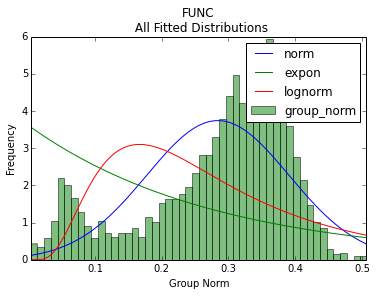

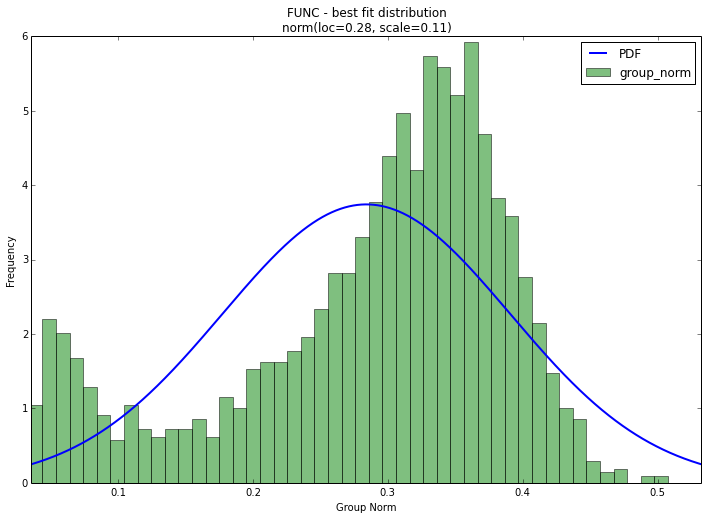

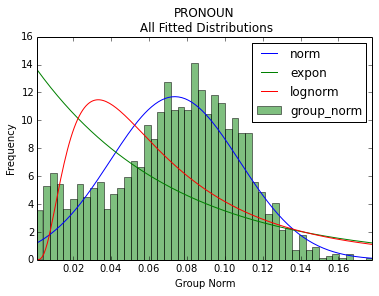

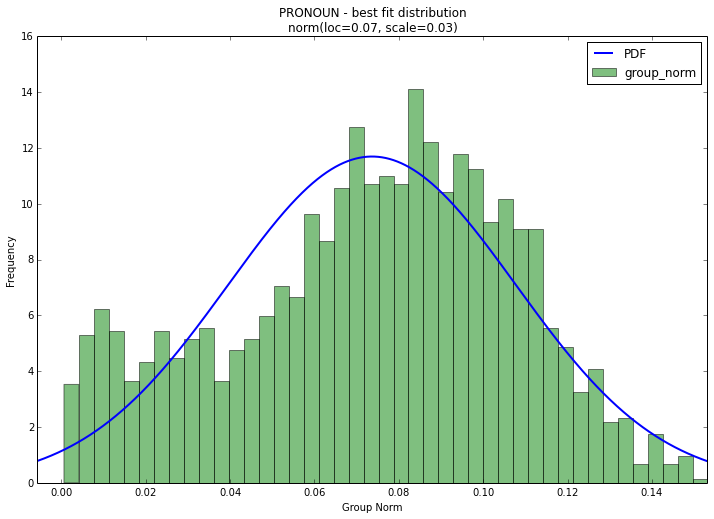

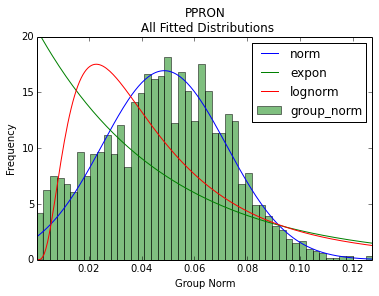

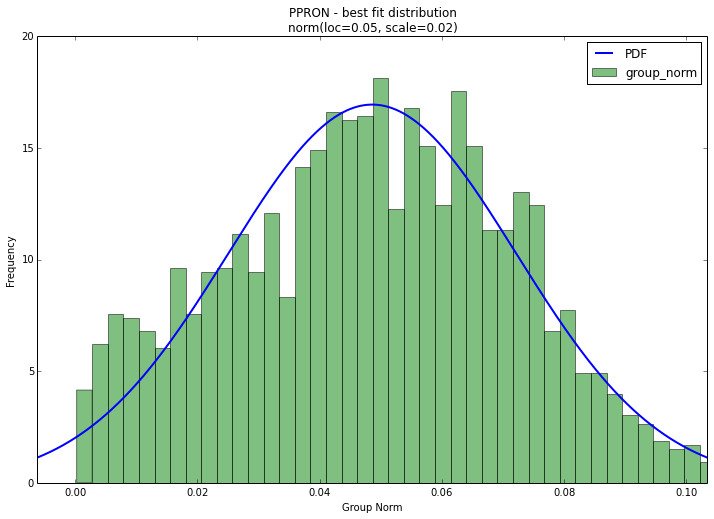

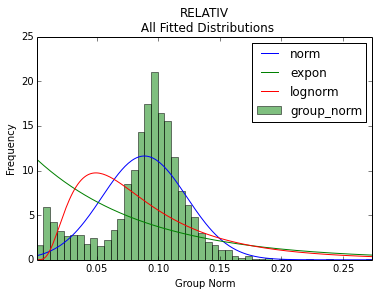

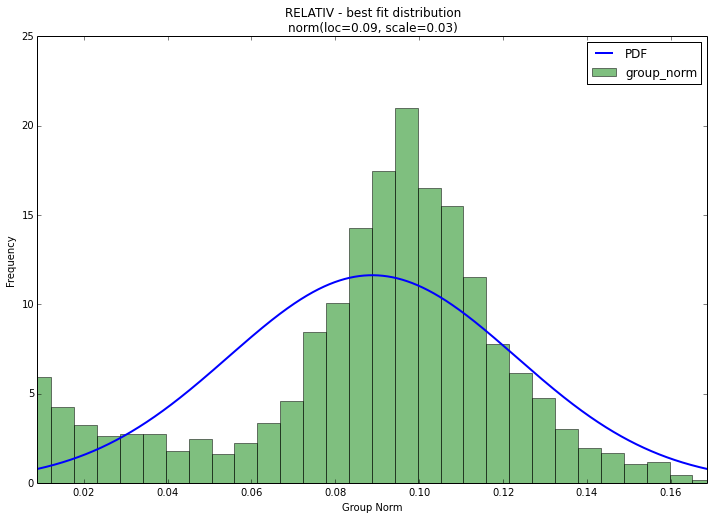

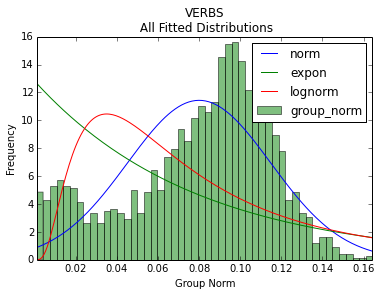

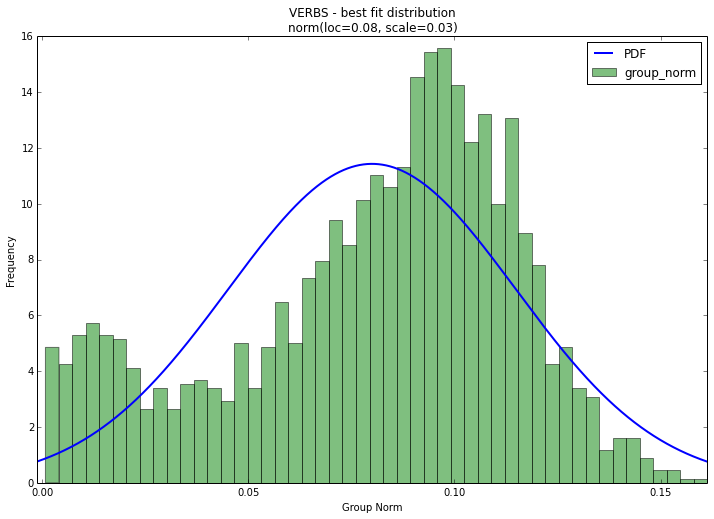

In [74]:
for feat in least_sse_feat:
    raw_df = pd.read_sql("select group_norm from " + table_name + " where feat = '" + feat + "'", con=engine)
    draw_plots(raw_df, feat)

# Worst Fitted Distributions
## The last five with maximum SSE

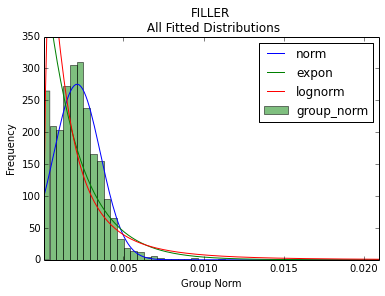

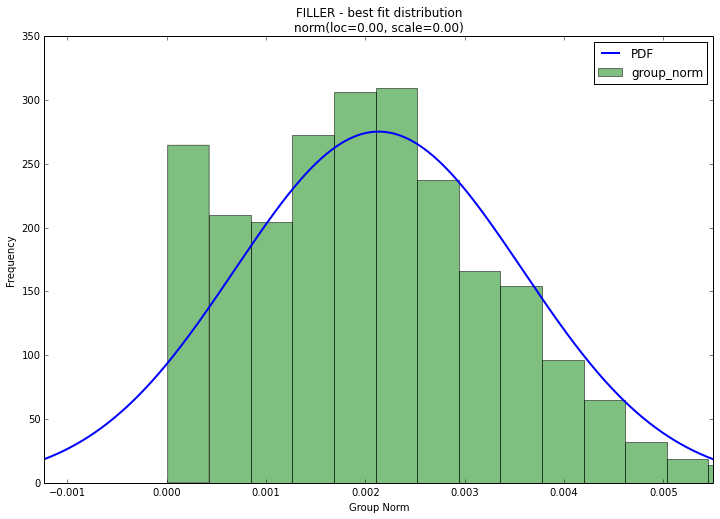

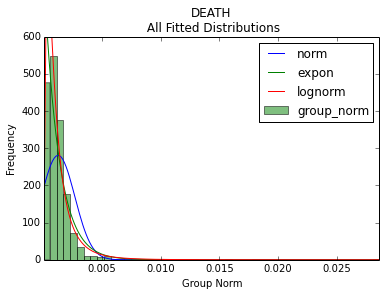

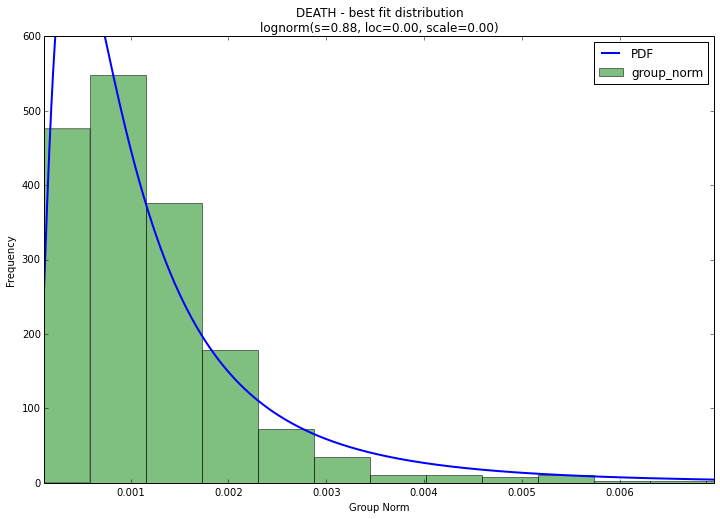

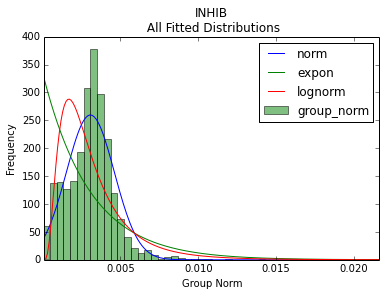

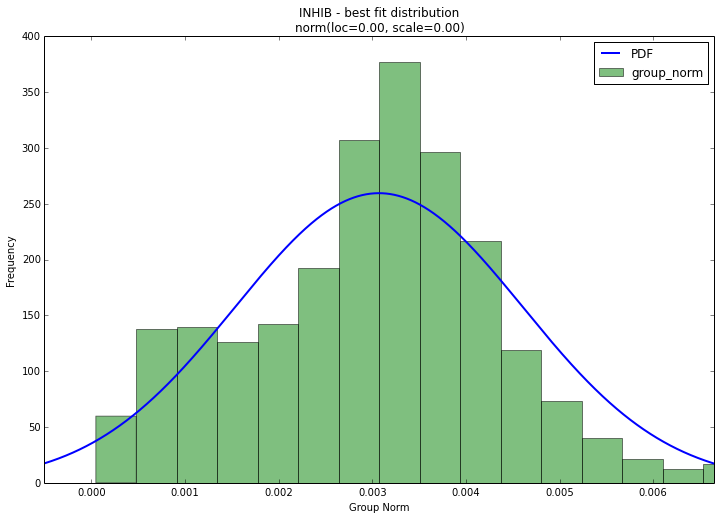

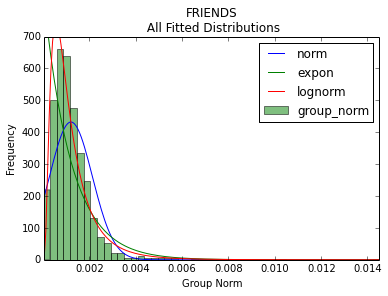

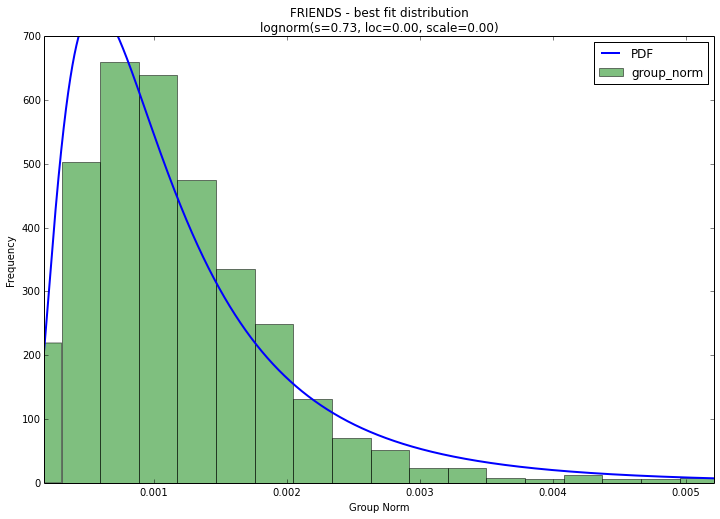

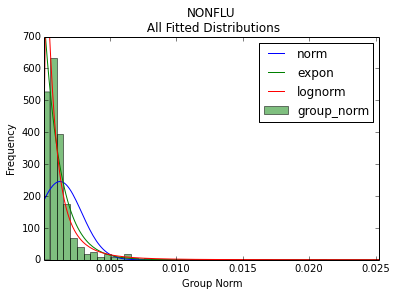

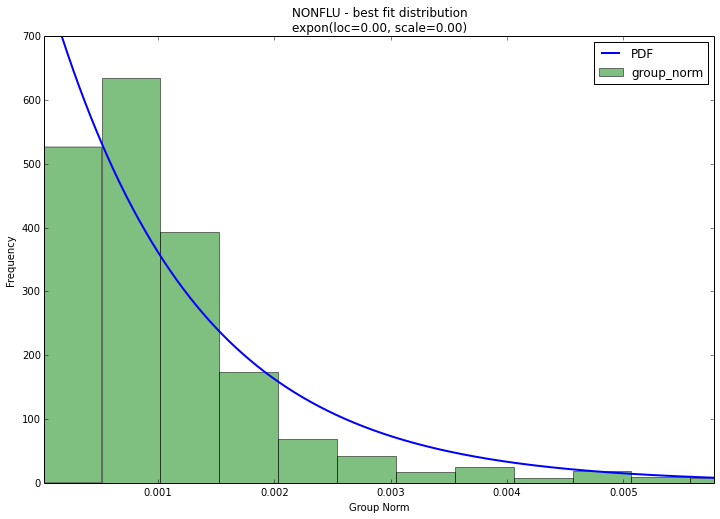

In [75]:
for feat in most_sse_feat:
    raw_df = pd.read_sql("select group_norm from " + table_name + " where feat = '" + feat + "'", con=engine)
    draw_plots(raw_df, feat)